<a id='home'></a>
### purpose

explore output of SLiM; apply code from CoAdaptree for training RONA

### outline

1. [convert 012 to pop-level allele frequencies](#convert)
    1. 012 file created in ../01_train_gradient_forests
1. [load environmental data](#envdata)
    1. map subpopID to environmental data
1. [estimate linear models](#linear)
    1. RONA only uses loci with significant linear models with the environment, estimate models here
1. [retrieve significant linear models](#sig)
    1. identify loci with significant linear models
1. [calculate the RONA](#rona)
    1. parallelize RONA calculation by first calculating 

In [1]:
from pythonimports import *
from IPython.display import Image
from scipy.stats import linregress

DIR = '/work/lotterhos/MVP-Offsets/practice_slim'
slimdir = op.join(DIR, 'mypractice')
training_dir = op.join(DIR, 'training')
rona_dir = makedir(op.join(training_dir, 'RONA'))

t1 = dt.now()  #notebook timer

lview,dview = get_client()

latest_commit()
session_info.show()

55 55
##################################################################
Current commit of pythonimports:
commit 357f2a9069d9ca25062146953c9bf88b70e863c0  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Feb 3 10:42:21 2022 -0500
Today:	February 16, 2022 - 09:25:13
python version: 3.8.5
##################################################################


In [2]:
seed = '1231094'

<a id='convert'></a>
# convert 012 to pop-level allele freqs

[top](#home)

#### get pop IDs

In [3]:
# get the 1000 individuals sampled from the 100 pops
subset = pd.read_table(op.join(slimdir, f'{seed}_Rout_ind_subset.txt'), delim_whitespace=True)
subset.index = ('i' + subset['indID'].astype(str)).tolist()  # this will match to the 'causal' file
subset['sample_name'] = subset.index.tolist()

print(nrow(subset))

subset.head()

1000


,seed,subpopID,indID,indSubpopIndex,subpop,phen_sal,phen_temp,sal_opt,temp_opt,fitness,subset,N,opt0,opt1,x,y,PC1,PC2,PC3,LFMM_U1_temp,LFMM_U1_sal,LFMM_U2_temp,LFMM_U2_sal,RDA1,RDA2,RDA_PC1,RDA_PC2,RDA_predict_tempPhen_20KSNPs,RDA_predict_salPhen_20KSNPs,sample_name
i0,1231094,1,0,0,1,0,-1.088090,-1.0,-1.0,0.984601,True,10,-1.0,-1.0,1,1,92.2154,-57.5673,-42.4980,-38.876285,72.935933,14.058057,40.216243,-2.464484,-4.413873,-2.401906,-2.096819,-5924.695082,-64.166353,i0
i1,1231094,1,1,1,1,0,-0.771927,-1.0,-1.0,0.901194,True,10,-1.0,-1.0,1,1,92.5184,-58.2218,-44.4978,-39.042619,73.119916,15.385371,40.384374,-2.472104,-3.013454,-2.412105,-2.206939,-5943.060707,-49.737004,i1
i2,1231094,1,2,2,1,0,-0.883133,-1.0,-1.0,0.973054,True,10,-1.0,-1.0,1,1,92.7162,-59.2298,-43.8789,-40.110397,73.313012,14.814410,41.455827,-2.478389,-3.995747,-2.476676,-2.159522,-5958.136915,-59.945481,i2
i3,1231094,1,3,3,1,0,-0.836002,-1.0,-1.0,0.947630,True,10,-1.0,-1.0,1,1,90.1391,-54.8804,-40.6813,-36.756808,71.370522,13.047852,38.074237,-2.409776,-2.373063,-2.273755,-2.013461,-5793.238241,-42.644448,i3
i4,1231094,1,4,4,1,0,-1.078760,-1.0,-1.0,0.987670,True,10,-1.0,-1.0,1,1,91.8586,-56.6580,-42.9090,-38.019264,72.297632,14.507998,39.346027,-2.443488,-4.116506,-2.350035,-2.134117,-5874.228034,-60.932578,i4


In [4]:
# assign samps to pop
samppop = dict(zip(subset.index, subset.subpopID))
popsamps = subset.groupby('subpopID')['sample_name'].apply(list).to_dict()

samppop['i0'], samppop['i911'], popsamps[1]

(1, 22, ['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'])

<a id='envdata'></a>
# load environmental data

[top](#home)

In [5]:
# assign subpopID to each individual's environmental data (same for each individual within a pop)
rangedata = subset[['y', 'x', 'sal_opt', 'temp_opt']].copy()
rangedata['popID'] = rangedata.index.map(samppop)
rangedata.head()

,y,x,sal_opt,temp_opt,popID
i0,1,1,-1.0,-1.0,1
i1,1,1,-1.0,-1.0,1
i2,1,1,-1.0,-1.0,1
i3,1,1,-1.0,-1.0,1
i4,1,1,-1.0,-1.0,1


In [6]:
# map population ID to environmental data
envdict = dict()
for env in ['sal_opt', 'temp_opt']:
    envdict[env] = rangedata.groupby('popID')[env].apply(np.mean).to_dict()

# show subset of envdata
for pop in range(1,10,1):
    print(pop, envdict['sal_opt'][pop], envdict['temp_opt'][pop])
for pop in range(90,100,1):
    print(pop, envdict['sal_opt'][pop], envdict['temp_opt'][pop])

1 -1.0 -1.0
2 -0.7777779999999999 -1.0
3 -0.555556 -1.0
4 -0.33333300000000005 -1.0
5 -0.11111099999999999 -1.0
6 0.11111099999999999 -1.0
7 0.33333300000000005 -1.0
8 0.555556 -1.0
9 0.7777779999999999 -1.0
90 1.0 0.7777779999999999
91 -1.0 1.0
92 -0.7777779999999999 1.0
93 -0.555556 1.0
94 -0.33333300000000005 1.0
95 -0.11111099999999999 1.0
96 0.11111099999999999 1.0
97 0.33333300000000005 1.0
98 0.555556 1.0
99 0.7777779999999999 1.0


In [7]:
# convert dict to dataframe - rownames = popID (note no zero index)
popenvdata = pd.DataFrame(envdict)
popenvdata.head()

,sal_opt,temp_opt
1,-1.000000,-1.0
2,-0.777778,-1.0
3,-0.555556,-1.0
4,-0.333333,-1.0
5,-0.111111,-1.0


<a id='linear'></a>
# estimate linear models

[top](#home)

In [8]:
def train(freqs):
    """Calculate linear regression slope, intercept, & p-val for each locus for each environmental variable."""
    from scipy.stats import linregress
    from tqdm import tqdm as pbar
    from collections import defaultdict
    from pythonimports import wrap_defaultdict
    
    freqs.columns = freqs.columns.astype(int)  # convert from string to int to avoid pop name lookup errors
    
    # estimate linear models
    results = wrap_defaultdict(tuple, 2)
    for env in popenvdata.columns:
        for locus in freqs.index:
            slope,intercept,rval,pval,stderr = linregress(popenvdata[env],
                                                          freqs[popenvdata.index].loc[locus])
            results[env][locus] = slope,intercept,pval
    
    return results

# dview['pop_freq'] = pop_freq
dview['popenvdata'] = popenvdata

In [9]:
# test function on first 5 loci
freqfile = op.join(training_dir,
                   f'gradient_forests/training_files/{seed}_plusneut_MAF01.recode2.vcf_GFready_pooled_all.txt')

train(
    pd.read_table(freqfile, index_col=0, nrows=5)
)

defaultdict(<function defaultdict.copy>,
            {'sal_opt': defaultdict(tuple,
                         {'LG1-50': (-0.0008181795347112591,
                           0.027000000000000003,
                           0.9335149362457733),
                          'LG1-67': (0.029863628494211737,
                           0.23949999999999996,
                           0.4899713586578689),
                          'LG1-125': (0.027545449668591453,
                           0.40700000000000003,
                           0.5498726978334352),
                          'LG1-148': (0.02822726819751686,
                           0.4065000000000001,
                           0.5400981955747808),
                          'LG1-185': (-0.020999999890905303,
                           0.086,
                           0.43515852794146503)}),
             'temp_opt': defaultdict(tuple,
                         {'LG1-50': (0.0139090729537217,
                           0.02700000000000000

In [10]:
# calculate linear models in parallel for each species
jobs = parallel_read(freqfile,
                     lview=lview,
                     dview=dview,
                     functions=create_fundict(train),
                     verbose=False,
                     maintain_dataframe=False,
                     index_col=0)

# gather results
results = defaultdict(dict)
for envdict in jobs:
    for env,locusdict in envdict.items():
        results[env].update(locusdict)

# save
seed = op.basename(freqfile).split("_")[0]
respkl = op.join(rona_dir, f'{seed}_linear_model_results.pkl')
pkldump(results, respkl)

respkl


Watching 55 parallel_read() jobs ...


1231094_plusneut_MAF01.recode2.vcf_GFready_pooled_all.txt: 100%|███████████████| 55/55 [00:00<00:00, 317313.23


Function `parallel_read` completed after : 0-00:00:08


'/work/lotterhos/MVP-Offsets/practice_slim/training/RONA/1231094_linear_model_results.pkl'

<a id='sig'></a>

# retrieve significant linear models

[top](#home)

In [11]:
# determine which of the loci had pvals <= 0.05
keep = defaultdict(list)
for env,locusdict in results.items():
    for locus,(slope,intercept,pval) in pbar(locusdict.items(), desc=env):
        if pval <= 0.05:
            keep[env].append(locus)

time.sleep(1)

for env,loci in keep.items():
    print(env, len(loci), len(results[env].keys()))

temp_opt: 100%|███████████████| 20807/20807 [00:00<00:00, 1792782.99it/s]


sal_opt 182 20807
temp_opt 15830 20807


In [12]:
popenvdata

,sal_opt,temp_opt
1,-1.000000,-1.0
2,-0.777778,-1.0
3,-0.555556,-1.0
4,-0.333333,-1.0
5,-0.111111,-1.0
...,...,...
96,0.111111,1.0
97,0.333333,1.0
98,0.555556,1.0
99,0.777778,1.0


<a id='rona'></a>
# calculate the RONA

- for each env for each pop, calculate RONA for each group of loci (for those loci with sig linear models)
- first calculate the typical summation element (google "parts of summation notation") of RONA in parallel
- then calculate RONA after gathering parallelized info

[top](#home)

In [13]:
# copy the equation screen shot from the offset validation repo
!cp $HOME/code/GitHub/offset_validation/RONA.png .

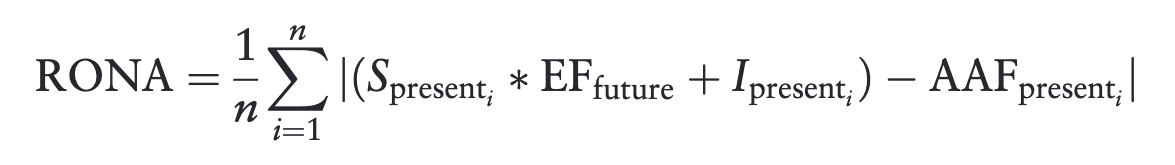

In [14]:
# from Rellstab et al. 2016 
# - this should really be RONA_p_e (RONA is calculated for a single pop for a single environmental variable)
Image(filename='RONA.png') 

In [15]:
def calc_rona_elements(garden, env, pop, aaf_present):
    """Calculate and return the abs element for each of n loci in `aaf_present.index`."""
    ef_fut = popenvdata[env].loc[garden]
    
    rona_elements = {}
    for locus_i in aaf_present.index:
        s_present, i_present, _pval = results[env][locus_i]
        # nans can be appended if locus has missing data for that pop, account for this when summing/avging
        rona_elements[locus_i] = abs(
            (s_present * ef_fut) + i_present - aaf_present[pop].loc[locus_i]
        )
    
    return rona_elements

dview['calc_rona_elements'] = calc_rona_elements
dview['results'] = results

def get_rona_elements(freqs):
    """Calculate the typical summation element of RONA for loci with significant linear models."""
    from collections import defaultdict
    from pythonimports import wrap_defaultdict
    
    freqs.columns = freqs.columns.astype(int)  # convert from string to int to avoid pop name lookup errors
    
    elements = wrap_defaultdict(None, 3)
    for env,loci in keep.items():
        interloci = set(loci).intersection(freqs.index)  # don't want whole table - need because freqs is a chunk
        for garden in pbar(popenvdata.index, desc=env):
            for pop in freqs.columns:
                elements[env][garden][pop] = calc_rona_elements(garden,
                                                                env,
                                                                pop,
                                                                freqs.loc[interloci])
    return elements
dview['keep'] = dict(keep)
dview['pbar'] = pbar

In [17]:
# test function
output = get_rona_elements(
    pd.read_table(freqfile, nrows=10, index_col=0)
)

output['temp_opt'][1][5]

temp_opt: 100%|███████████████| 100/100 [00:04<00:00, 24.95it/s]


{'LG1-125': 0.27800000534539465,
 'LG1-198': 0.28236367447605504,
 'LG1-148': 0.2770909149644027,
 'LG1-222': 0.28236367447605504,
 'LG1-185': 0.28236367447605504,
 'LG1-358': 0.2869091263810141,
 'LG1-67': 0.4561817937379841}

In [18]:
# calculate rona elements in parallel
jobs = parallel_read(freqfile,
                     lview=lview,
                     dview=dview,
                     verbose=False,
                     index_col=0,
                     functions=create_fundict(get_rona_elements),
                     maintain_dataframe=False)

# gather elements
rona_elements = wrap_defaultdict(dict, 3)
for j in pbar(jobs, desc='extracting element data'):
    for env,gardendict in j.items():
        for garden,popdict in gardendict.items():
            for pop,elementdict in popdict.items():
                # `elementdict` is returned from `calc_rona_elements` - key=locus, val=summation_element
                rona_elements[env][garden][pop].update(elementdict)




Watching 55 parallel_read() jobs ...


1231094_plusneut_MAF01.recode2.vcf_GFready_pooled_all.txt: 100%|███████████████| 55/55 [01:40<00:00,  1.83s/it


Function `parallel_read` completed after : 0-00:01:48


extracting element data: 100%|███████████████| 55/55 [00:21<00:00,  2.55it/s]


In [19]:
# Calculate the real rona by summing and averaging elements

rona = wrap_defaultdict(None, 3)  # one RONA per pop per climate
rona_loci_counts = wrap_defaultdict(None, 3)
all_counts = wrap_defaultdict(list, 2)

for env,gardendict in rona_elements.items():
    for garden,popdict in pbar(gardendict.items(), desc=env):
        for pop,elementdict in popdict.items():
            # make sure I got what I was expecting to get - number of loci with sig linear models
            assert len(elementdict) == len(keep[env])

            # for each group of loci, calc RONA by according to equation above by 
                # averaging rona_elements while accounting for missing data
            
            # get all of the typical summation elements for loci within `keep[env]` that have sig models
                # these should all be in `elementdict.keys()`
            interloci = set(keep[env]).intersection(elementdict.keys())
            assert len(interloci) == len(keep[env]) == len(elementdict.keys())
            
            elements = [elementdict[locus] for locus in interloci]
            if sum(el==el for el in elements) > 0:
                # if at least one instance of non-np.nan data:
                _mean = np.nanmean(elements)  # np.nanmean accounts for missing data
            else:
                # avoid RuntimeWarning: Mean of empty slice
                # this happens when a pop has missing data at all of the few number of loci given (eg 2)
                    # and each `el` in `elements` was therefore `np.nan`
                    # this would only happen with empirical data ++ when the loci set is very small
                _mean = np.nan
                
            rona[env][garden][pop] = _mean
            rona_loci_counts[env][garden][pop] = len(interloci)
            all_counts[garden][env].append(interloci)

temp_opt: 100%|███████████████| 100/100 [07:20<00:00,  4.40s/it]


In [20]:
# save RONA results
rona_file = op.join(rona_dir, f'{seed}_RONA_results.pkl')
pkldump(rona, rona_file)

rona_file

'/work/lotterhos/MVP-Offsets/practice_slim/training/RONA/1231094_RONA_results.pkl'

In [21]:
# save this - do I really need to save it?
countfile = op.join(rona_dir, f'{seed}_RONA_loci_counts.pkl')
pkldump(rona_loci_counts, countfile)

countfile

'/work/lotterhos/MVP-Offsets/practice_slim/training/RONA/1231094_RONA_loci_counts.pkl'

In [22]:
# how long did this take?
formatclock(dt.now() - t1, exact=True)

'0-00:09:55'